This program will calculate an estimate and error for the radioactivity of our ${}^{210}Po$ sample. Ostensibly it could also estimate the mass of the sample.

Reminder: The variance of a poisson distribution is $\sqrt{N}$

In [1]:
from scipy import constants
curie = 3.7E10 # decays / second

In [2]:
# collect data from the minimum pressure spectra

from os import walk
import re
from mca import extract_data
from matplotlib import pyplot as plt
import numpy as np

path = 'datafiles/7torr'
filenames = next(walk(path), (None, None, []))[2]

bq = []
σ_live = 1
σ_bq = []

for filename in filenames:
    if filename.startswith('spectrum'):
        pressure = re.findall('\d+', filename)[0] # torr
        pressure = int(pressure)
        data = extract_data(path + '/' + filename)
        counts = sum(data['data'])
        livetime = data['meas_live']
        bq.append(counts / livetime)
        σ_N = np.sqrt(counts)
        σ_bq.append(
            np.sqrt(σ_N**2 + counts**2*σ_live**2/livetime**2) / livetime
        )

In [3]:
bq = np.array(bq)
σ_bq = np.array(σ_bq)

print(bq)
print(σ_bq)

[26.64935065 26.88311688 25.64935065 25.64935065 25.28571429]
[0.68255222 0.68631197 0.66638554 0.66638554 0.66047195]


The standard error of the weighted mean (with variance weights) is:

$$\sigma_x = \sqrt{\frac{1}{\sum_{i=1}^n \frac{1}{\sigma_{i}}}}$$

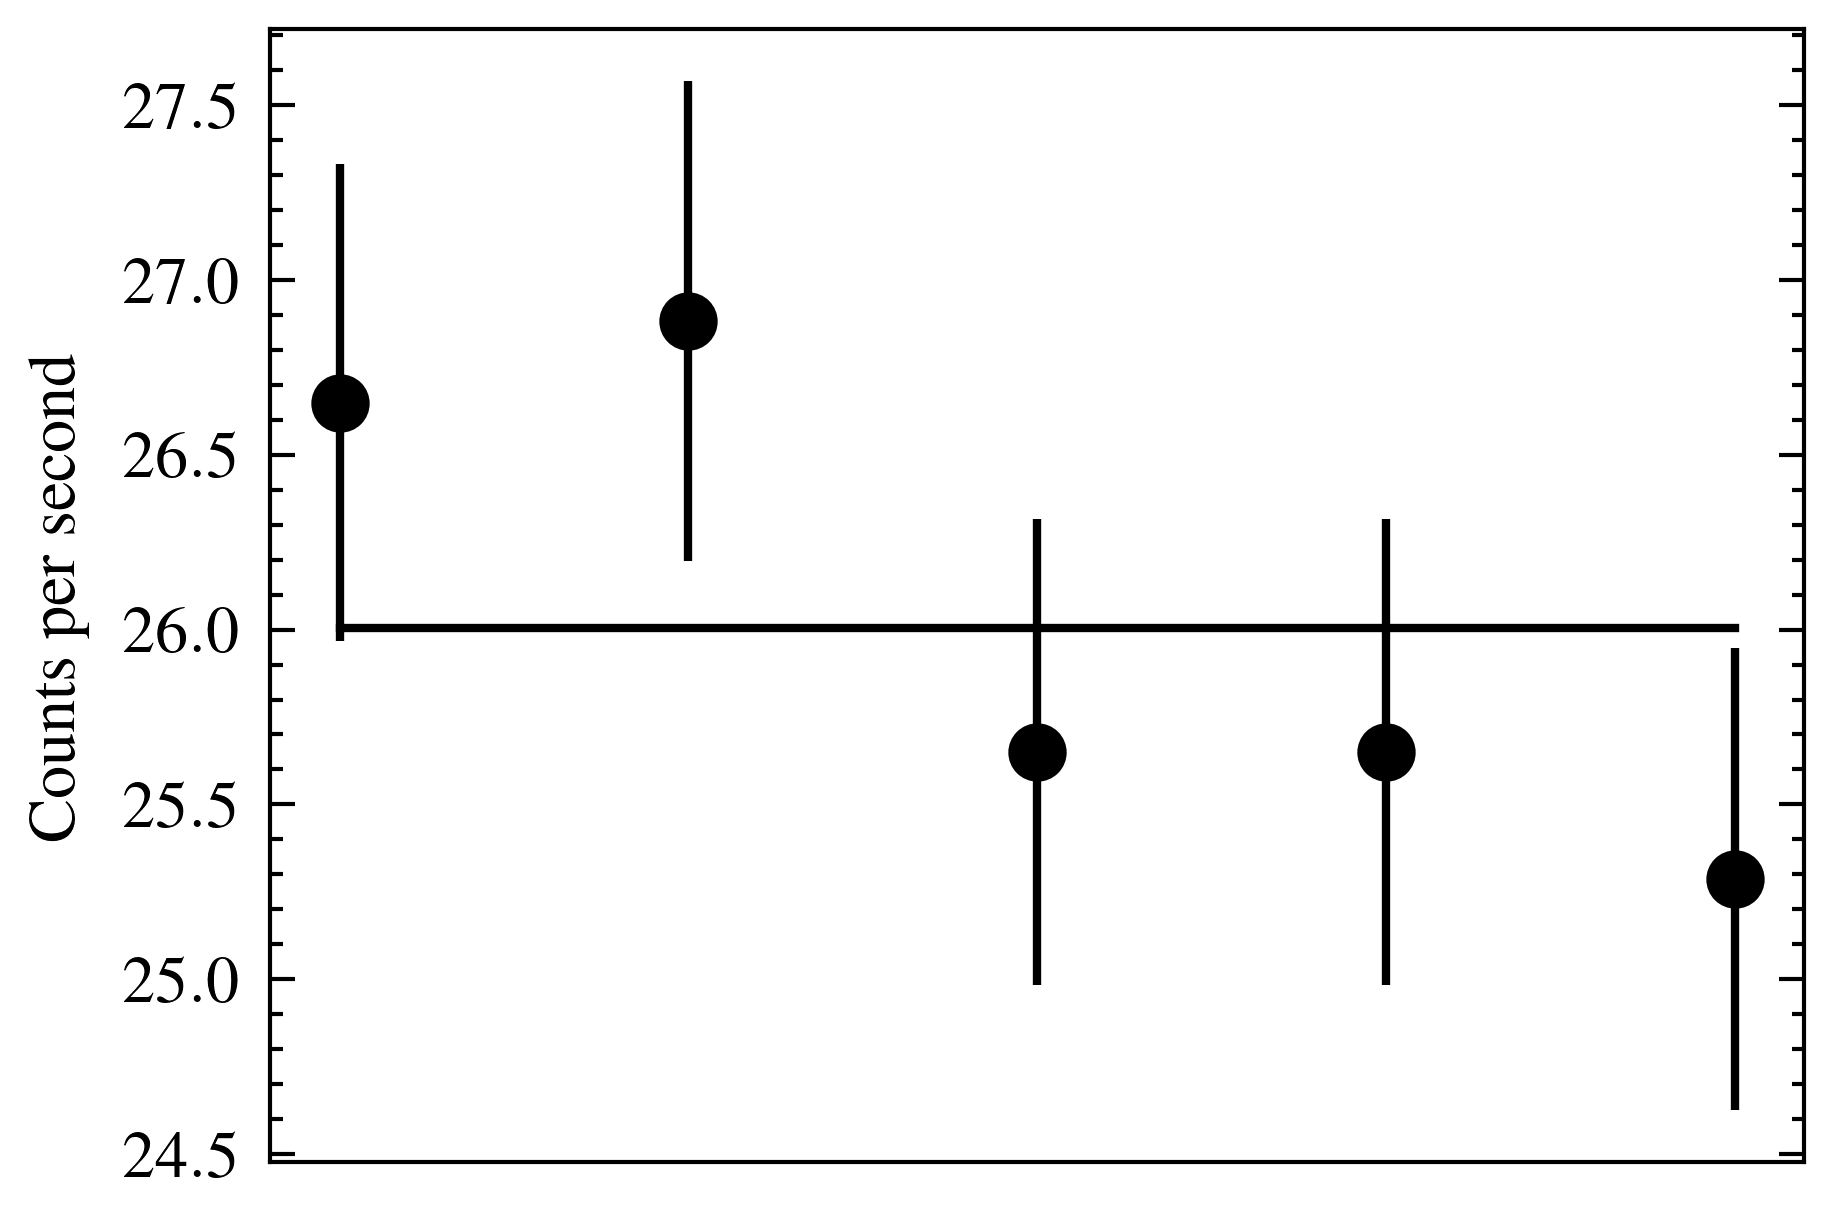

In [14]:
bq_bar = np.average(bq, weights=1/σ_bq**2)
σ_bq_bar = np.sqrt(1/np.sum(1/σ_bq**2))

plt.style.use('ieee')

plt.plot(np.arange(len(bq)), bq_bar*np.ones(len(bq)))
plt.errorbar(np.arange(len(bq)), bq, yerr=σ_bq, fmt='o', color='black')
plt.ylabel('Counts per second')
plt.xticks([])
plt.show()

In [15]:
print("The average counts per second is", bq_bar)
print("The uncertainty in the average counts per second is", σ_bq_bar)

The average counts per second is 26.004701361521022
The uncertainty in the average counts per second is 0.30061463060383997


$$\text{counts / second} = 26.00 \pm 0.30$$

On page 3 of my lab notebook I calculate the solid angle subtended by the detector (with a standard deviation due to measurement uncertainty) in milli-sterradians.

$$81.4 \pm 7.3 \text{ msr}$$

In [16]:
# ratio of particles that would hit the detector to total emissions
s = 81.4e-3/(4*np.pi)
σ_s = 7.3e-3/(4*np.pi)

In [19]:
emissionsPerSecond = bq_bar/s

print("Radioactivity is:", emissionsPerSecond/curie/constants.micro, "µci")
σ_emissionsPerSecond = np.sqrt(σ_bq_bar**2 + s**2*σ_bq_bar**2/s**2)/s
print("Uncertainty in radioactivity is:", σ_emissionsPerSecond/curie/constants.micro, "µci")
print("Radioactivity is:", emissionsPerSecond, "+-", σ_emissionsPerSecond)
halflife = 138.378*24*60**2 # seconds
molar_mass = 209.98 # g/mol
atoms = halflife*emissionsPerSecond/np.log(2)
σ_atoms = halflife*σ_emissionsPerSecond/np.log(2)
σ_grams = σ_atoms*209.98/constants.N_A
print("Grams of Polonium-210:", atoms*209.98/constants.N_A / constants.nano , "ng")
print("Uncertainty in grams of Polonium-210:", σ_grams / constants.nano, "ng")

Radioactivity is: 0.10850146590895934 µci
Uncertainty in radioactivity is: 0.0017738171369554162 µci
Radioactivity is: 4014.5542386314955 +- 65.63123406735039
Grams of Polonium-210: 0.0241445819171464 ng
Uncertainty in grams of Polonium-210: 0.0003947234519872203 ng


The measured radioactivity of our sample is $0.1085 \pm 0.0018$ µci, which is likely correct since [the posting](https://www.pasco.com/products/lab-apparatus/atomic-and-nuclear/sn-9085) sells them in $0.1$ µci samples.